# Exploring and cleaning the dataset

IMPORTANT REMARK:

This code shall be executed from start to finish in the defined order. Errors may occur if the cells are executed in a different order.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import operator

matplotlib.style.use('ggplot')
%matplotlib inline

The dataset consists on two files:
- outcomes.tsv: this file is based on information published directly by Swoopo, which contains limited information about an auction: the description of the product, its retail price and selling price, the winnner of the auction, the number of placed bids, etc.
- traces.tsv: this file is based on traces of live auctions that the authors of the dataset recorded using  their  own  recording  infrastructure. It contains the record of the bids that were placed for several auctions, including the user who placed each bid, the bidding time, etc.

The dataset can be found in the following link:
http://people.bu.edu/zg/swoopo.html

Dataset authors:

Byers, J. W., Mitzenmacher, M., & Zervas, G. (2010, June). Information asymmetries in pay-per-bid auctions. In Proceedings of the 11th ACM conference on Electronic commerce (pp. 1-12). ACM.

In [2]:
outcomesDf = pd.read_csv('./outcomes.tsv',sep='\t')
tracesDf = pd.read_csv('./traces.tsv',sep='\t')

# outcomes.tsv

The file outcomes.tsv included in the dataset contains the following columns:

- auction_id: unique numerical id for the auction
- product_id: unique product id
- item: text string describing the product
- desc: more information about the product
- retail: the stated retail value of the item, in dollars
- price: the price the auction reached, in dollars
- finalprice: the price charged to the winner in dollars. For certain types of auctions, the value in this column may differ from the value specified in column "price". For example, this may happen in fixed-price auctions or 100%-off auctions (auctions in which the final selling price of the product is zero, and the revenue for Swoopo comes exclusively from the bids that are placed).
- bidincrement: the price increment of a bid, in cents
- bidfee: the cost incurred to make a bid, in cents
- winner: the winner's username
- placedbids: the number of paid bids placed by the winner
- freebids: the number of free bids placed by the winner. Free bids are offered by Swoopo in certain deal packages, and users placing free bids do not incur in any bid fee.
- endtime_str: the auction's end time.
- flg_click_only: a binary flag indicating a "NailBiter" auction (Swoopo  auctions  which  do  not
permit the use of automated bids by a BidButler, which are automatic bidding agents provided by the Swoopo interface that bid according to user-defined instructions. Users are able to define starting and ending price limits for which automated bids shall be placed, as well as the top number of bids that the BidButler is allowed to place. BidButlers place automated bids when the auction timer drops below 10 seconds).
- flg_beginnerauction: a binary flag indicating a beginner auction (auctions restricted to users who haven't previously won any auction in the site).
- flg_fixedprice: a binary flag indicating a fixed-price auction (an auction in which the selling price is fixed from the beginning). 
- flg_endprice: a binary flag indicating a 100%-off auction (auctions in which the final selling price of the product is zero, and the revenue for Swoopo comes exclusively from the bids that are placed).

In [3]:
outcomesDf.head(2)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0


The types of the values seem to be appropiate, except for the type of the "endtime_str" column. It is better to convert this column to DateTime objects, so that it is possible to use DateTime functions afterwards.

In [4]:
outcomesDf.dtypes

auction_id               int64
product_id               int64
item                    object
desc                    object
retail                 float64
price                  float64
finalprice             float64
bidincrement             int64
bidfee                   int64
winner                  object
placedbids               int64
freebids                 int64
endtime_str             object
flg_click_only           int64
flg_beginnerauction      int64
flg_fixedprice           int64
flg_endprice             int64
dtype: object

In [5]:
outcomesDf['endtime_str'] = pd.to_datetime(outcomesDf['endtime_str'])

There are no empty values in the dataset file:

In [6]:
outcomesDf.isnull().values.any()

False

The columns "retail", "price" and "finalprice" are all expressed in dollars, which the columns "bidincrement" and "bidfee" are both expressed in cents. These last two columns have been converted to dollars:

In [7]:
outcomesDf['bidincrement']=outcomesDf['bidincrement']/100
outcomesDf['bidfee']=outcomesDf['bidfee']/100

The dataset file includes 121419 auctions that took place between 2008-08-20 and 2009-12-12

In [8]:
print("Number of auctions: " + str(outcomesDf.shape[0]))
print("First auction date: " + str(min(outcomesDf['endtime_str'])))
print("Last auction date: " + str(max(outcomesDf['endtime_str'])))

Number of auctions: 121419
First auction date: 2008-08-20 14:04:00
Last auction date: 2009-12-12 15:10:00


The price increment of the final price of the item after each bid depends on the auction. In the dataset, it ranges from 1 cent to 24 cents:

In [9]:
np.sort(outcomesDf['bidincrement'].unique())

array([ 0.01,  0.02,  0.05,  0.06,  0.07,  0.12,  0.15,  0.24])

The bid fee also depends on the auction. In the dataset, it ranges from 60 cents to 75 cents:

In [10]:
np.sort(outcomesDf['bidfee'].unique())

array([ 0.6 ,  0.75])

The number of bids that were placed for each auction can be obtained from the price the auction reached and the price increment of each bid:

In [11]:
outcomesDf['bids_placed'] = outcomesDf['price']/(outcomesDf['bidincrement'])

Free bids are offered by Swoopo in certain deal packages. Of all of the bids placed in a certain auction, some can be free bids, which increment the price of the item, but the user does not incur in any bid fee by placing them. With the information provided by this dataset file, there is no information that can allow us to determine how many free bids were placed and how many of them were non-free bids. The only data that the dataset provides is the number of paid bids placed by the winner and the number of free bids placed by the winner. Since the dataset contains this information for 121419 auctions, in average, the ratio between the total number of free bids and paid bids placed in a certain auction can be approximated by the ration of the ones placed by the auction winners.

Of all of the bids placed in the dataset by all winners, 414321 bids were free bids and 9098807 were paid bids. The ratio between free bids and paid bids is then 4.55%

In [12]:
print("Total number of free bids: "+str(np.sum(outcomesDf['freebids'])))
print("Total number of paid bids: "+str(np.sum(outcomesDf['placedbids'])))
ratioFreeBidsPaidBids = np.sum(outcomesDf['freebids'])/np.sum(outcomesDf['placedbids'])
print("Ratio free bids/paid bids: "+str(ratioFreeBidsPaidBids))

Total number of free bids: 414321
Total number of paid bids: 9098807
Ratio free bids/paid bids: 0.04553574990655369


Taking account into account this approximation, the total money that Swoopo obtains for an auction is the number of non-free bids placed by all participants (approximated as a 95.45% of the total number of bids placed) multiplied by the bid fee, plus the final selling price of the item paid by the winner. 

In [13]:
outcomesDf['swoopo_sale_price'] = (1-ratioFreeBidsPaidBids)*outcomesDf['bids_placed']*(outcomesDf['bidfee']) + outcomesDf['finalprice']

Therefore, the profit that Swoopo obtains over the retail price of the item is:

In [14]:
outcomesDf['swoopo_profit'] = outcomesDf['swoopo_sale_price']-outcomesDf['retail']

The money that the winner pays for the item is the item's final price, plus the number of paid bids that he/she placed multiplied by the bid fee. Therefore, the difference between the retail price and the money that the winner paid for the item is the winner's benefit over the retail price of the item:

In [15]:
outcomesDf['winner_benefit'] = outcomesDf['retail'] - (outcomesDf['finalprice'] + outcomesDf['bidfee'] * outcomesDf['placedbids'])

In order to identify the different items sold in the auctions, the columns "product_id", "item" and "desc" can be used. An analysis of the unique values contained in these columns is now performed. Each one of them contains a different number of unique values. 

In [16]:
len(outcomesDf['product_id'].unique())

2081

In [17]:
len(outcomesDf['item'].unique())

1803

In [18]:
len(outcomesDf['desc'].unique())

1779

The following function counts the number of appearances in the dataset of each unique value of the columns "product_id", "item" and "desc", and creates a new DataFrame indicating the count number along with the original column values.

In [19]:
def compareProductIdItemDescColumnValues():
    outcomesDfItemDesc =outcomesDf[['product_id','item','desc','endtime_str']]
    productIdColumnValueCounts = outcomesDf['product_id'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(productIdColumnValueCounts.to_frame(),how='left',left_on='product_id',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'product_id_x': 'product_id', 'product_id_y': 'product_id_count'})

    itemColumnValueCounts = outcomesDf['item'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})

    descColumnValueCounts = outcomesDf['desc'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
    
    return outcomesDfItemDesc

In [20]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
outcomesDfItemDesc.head()

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
1,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-08-28 11:17:00,21,60,60
2,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-11-07 22:52:00,21,60,60
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
4,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-24 14:23:00,33,77,77


The "product_id" column contains different values for rows of the dataset in which the same item is sold. Therefore, the "product_id" value is not a good option to identify unique products.

Here is an example of different auctions in which the item "Sony Ericsson S500i Unlocked Mysterious Green" is sold, but the "product_id" value is different each time:

In [21]:
productIdVsItemDf = outcomesDfItemDesc[(outcomesDfItemDesc['product_id_count']!=outcomesDfItemDesc['item_count'])].drop_duplicates(subset=['product_id','item','desc'])
productIdVsItemDf[productIdVsItemDf['item'].values == 'sony-ericsson-s500i-unlocked-mysterious-']

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
5,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-22 22:44:00,15,77,77
17,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-02 00:06:00,11,77,77
17297,10010727,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-11-11 01:46:00,8,77,77


Also, in some cases, some items do not contain a description in the column "desc", and the "item" column is the name of an HTML page:

In [22]:
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36
21421,10010818,123553.html,-,2008-11-30 23:24:00,36,1,36
22803,10010818,125284.html,-,2008-12-07 17:10:00,36,1,36
22804,10010818,125285.html,-,2008-12-05 13:18:00,36,1,36
22805,10010818,125286.html,-,2008-12-03 19:51:00,36,1,36
22806,10010818,125287.html,-,2008-12-02 16:39:00,36,1,36


This is the case for 36 rows in the dataframe.

In [23]:
itemVsDescDf[itemVsDescDf.apply(lambda x : "html" in x['item'], axis=1)]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36
21421,10010818,123553.html,-,2008-11-30 23:24:00,36,1,36
22803,10010818,125284.html,-,2008-12-07 17:10:00,36,1,36
22804,10010818,125285.html,-,2008-12-05 13:18:00,36,1,36
22805,10010818,125286.html,-,2008-12-03 19:51:00,36,1,36
22806,10010818,125287.html,-,2008-12-02 16:39:00,36,1,36


Since auctions with missing product descriptions would not be very helpful for performing data analysis, and this only happens for a small number of rows, it has been decided to discard these rows.

In [24]:
htmlItems = ['109104.html', '109746.html', '109786.html', '109830.html',
       '110013.html', '110869.html', '111506.html', '111584.html',
       '112103.html', '112187.html', '114652.html', '114804.html',
       '114907.html', '116626.html', '117910.html', '118838.html',
       '121129.html', '121215.html', '121470.html', '121471.html',
       '121788.html', '121881.html', '123276.html', '123553.html',
       '125284.html', '125285.html', '125286.html', '125287.html',
       '125288.html', '126865.html', '126866.html', '126867.html','130108.html',
       '137897.html', '137898.html', '140035.html']
outcomesDf = outcomesDf[~outcomesDf['item'].isin(htmlItems)]

In most of the cases in which there are different values in the column "desc" for the same value of the column "item", it is due to small grammar differences in the text contained in the column "desc":

In [25]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
30862,10011491,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera,2009-01-05 02:42:00,43,48,43
25280,10010929,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera - RED,2008-12-10 13:43:00,5,48,5
52065,10011838,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-03-15 17:43:00,6,21,6
60454,10012069,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-04-17 21:05:00,8,21,15
7691,10009192,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 ( 5/8"" Inch)",2008-10-06 13:23:00,26,37,26
17351,10011006,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 (5/8"" Inch)",2008-11-08 11:47:00,11,37,11
77943,10012229,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-29 04:30:00,22,37,22
74852,10012230,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-15 07:13:00,15,37,15
506,10008900,lego-city-7743-police-command-center,LEGO City 7743 - Police Command Center,2008-08-21 23:23:00,3,6,3
7652,10010875,lego-city-7743-police-command-center,LEGO City 7743: Police Command Center,2008-10-03 18:48:00,3,6,3


For example, for the item "vtech-v-smile-tv-learning-system" there are two descriptions that actually refer to the same item, but are written slightly differently:

In [26]:
itemVsDescDf[itemVsDescDf['item'].values == "vtech-v-smile-tv-learning-system"]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
503,10009529,vtech-v-smile-tv-learning-system,VTech V.Smile TV Learning System,2008-08-23 05:53:00,4,22,4
13766,10011031,vtech-v-smile-tv-learning-system,Vtech - V.Smile TV Learning System,2008-11-03 04:59:00,18,22,18


The following code lines are used to clean these small differences:

In [27]:
outcomesDf.loc[outcomesDf['item'].values=="vtech-v-smile-tv-learning-system", 'desc'] = "Vtech - V.Smile TV Learning System"
outcomesDf.loc[outcomesDf['item'].values=="lego-city-7743-police-command-center", 'desc'] = "LEGO City 7743 - Police Command Center"
outcomesDf.loc[outcomesDf['item'].values=="samsung-t220hd-22-1080p-lcd-hdtv-monitor", 'desc'] = "Samsung T220HD 22\" 1080p LCD HDTV Monitor"
outcomesDf.loc[outcomesDf['item'].values=="ghd-professional-mini-styler-mk4-5-8-inc", 'desc'] = "GHD Professional Mini Styler MK4 (5/8\" Inch)"
outcomesDf.loc[outcomesDf['item'].values=="frigidaire-atf8000fs-white-front-loading", 'desc'] = "Frigidaire ATF8000FS White Front-Loading Washer"
outcomesDf.loc[outcomesDf['item'].values=="lg-26-5-cu-ft-side-by-side-refrigerator-", 'desc'] = "LG 26.5 cu.ft. Side-By-Side Refrigerator (White)"
outcomesDf.loc[outcomesDf['item'].values=="samsung-bd-p3600-1080p-blu-ray-disc-play", 'desc'] = "Samsung BD-P3600 1080p Blu-Ray Disc Player"
outcomesDf.loc[outcomesDf['item'].values=="garmin-n-vi-205w-4-3-inch-portable-gps-n", 'desc'] = "Garmin nüvi 205W 4.3-Inch Portable GPS Navigator"
outcomesDf.loc[outcomesDf['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam", 'desc'] = "Casio Exilim EX-Z200 10.1 MP Digital Camera"

After cleaning the previous product descriptions, the only items left with the same value for the "item" column but with a different value for the "desc" column are two games available in different gaming devices. Since they are conceptually different products, it has been decided to leave the values for the column "desc" as they are.

In [28]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
106950,10013994,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (DS),2009-10-25 03:33:00,55,110,55
106964,10013993,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (Wii),2009-10-25 14:03:00,55,110,55
115882,10014797,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (PC),2009-11-15 18:38:00,24,52,24
106978,10013992,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (Wii),2009-10-24 19:36:00,28,52,28


As it has been mentioned in the dataset file description, there are special types of auctions:
- Click-only auctions: Swoopo auctions which do not permit the use of automated bids by a BidButler.
- Beginner auctions: auctions restricted to users who have not yet won any auctions.
- Fixed-price auctions: auctions in which the selling price is fixed from the beginning.
- End-price auctions: auctions in which the final selling price of the product is zero.

The type of auction in the dataset is indicated with flags with values 0 and 1:

In [29]:
outcomesDf[['auction_id','bidincrement','bidfee','flg_click_only','flg_beginnerauction','flg_fixedprice','flg_endprice']].head()

,auction_id,bidincrement,bidfee,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,0.15,0.75,0,0,0,0
1,87964,0.15,0.75,0,0,0,0
2,87965,0.15,0.75,0,1,0,0
3,88638,0.15,0.75,0,0,0,0
4,88639,0.15,0.75,0,0,0,0


Auctions can have a combination of different types at the same time. The following table represents the number of auctions for each different combination of types:

In [30]:
countOfTypesOfAuctions = outcomesDf.groupby(['flg_click_only','flg_beginnerauction','flg_fixedprice','flg_endprice'])['auction_id'].count()
countOfTypesOfAuctions

flg_click_only  flg_beginnerauction  flg_fixedprice  flg_endprice
0               0                    0               0               70020
                                                     1                3542
                                     1               0                1968
                1                    0               0               12891
                                                     1                 168
                                     1               0                  40
1               0                    0               0               25335
                                                     1                 814
                                     1               0                 155
                1                    0               0                6413
                                                     1                  32
                                     1               0                   5
Name: auction_id, dtype: int64

Now, we count separately the number of click-only auctions, beginner auctions, fixed-price auctions, end-price auctions, and 'other' auctions (which are the ones that are not included in the other four categories mentioned before).

In [31]:
isClickOnlyAuction = outcomesDf['flg_click_only'].values == 1
isBeginnerAuction = outcomesDf['flg_beginnerauction'].values == 1
isFixedPriceAuction = outcomesDf['flg_fixedprice'].values == 1
isEndPriceAuction = outcomesDf['flg_endprice'].values == 1

totalNumberOfAuctions = outcomesDf.shape[0]
totalNumberOfClickOnlyAuctions = outcomesDf[isClickOnlyAuction].shape[0]
totalNumberOfBeginnerAuctions = outcomesDf[isBeginnerAuction].shape[0]
totalNumberOfFixedPriceAuctions = outcomesDf[isFixedPriceAuction].shape[0]
totalNumberOfEndPriceAuctions = outcomesDf[isEndPriceAuction].shape[0]
totalNumberOfNormalAuctions = totalNumberOfAuctions - (totalNumberOfClickOnlyAuctions+totalNumberOfBeginnerAuctions+totalNumberOfFixedPriceAuctions+totalNumberOfEndPriceAuctions)

print('Total number of auctions = %d'%totalNumberOfAuctions)
print('Total number of click-only auctions = %d'%totalNumberOfClickOnlyAuctions)
print('Total number of beginner auctions = %d'%totalNumberOfBeginnerAuctions)
print('Total number of fixed-price auctions = %d'%totalNumberOfFixedPriceAuctions)
print('Total number of end-price auctions = %d'%totalNumberOfEndPriceAuctions)
print('Total number of \'other\' auctions = %d'%totalNumberOfNormalAuctions)

Total number of auctions = 121383
Total number of click-only auctions = 32754
Total number of beginner auctions = 19549
Total number of fixed-price auctions = 2168
Total number of end-price auctions = 4556
Total number of 'other' auctions = 62356


As it has been mentioned before, the column 'swoopo_profit' indicates the profit that Swoopo obtains over the retail price of the item. Sometimes, Swoopo obtaines a negative profit (i.e., Swoopo sells an item below its retail price).

This is the case for 47.53% of the auctions.

In [32]:
totalNumberOfNegativeProfitAuctions = outcomesDf[outcomesDf['swoopo_profit'] < 0].shape[0]
(totalNumberOfNegativeProfitAuctions/totalNumberOfAuctions)*100

47.530543815855594

Nevertheless, the average profit (in dollars) obtained by Swoopo over the retail price of the items is positive:

In [33]:
averageProfitPerItem = outcomesDf['swoopo_profit'].mean()
averageProfitPerItem

197.35105563510265

Naturally, users are motivated to place bids because if they win the auction they will most likely buy the item for a price that is much lower than its retail price. In average, this is the benefit in dollars that the winner obtains over the retail price of the item:

In [34]:
outcomesDf['winner_benefit'].mean()

161.6076518128433

The average number of auctions per day is approximately 253:

In [35]:
f = lambda x: str(x.day) + '-' + str(x.month) + '-' + str(x.year)
auctionsPerDay = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['auction_id'].count()
averageNumberOfDailyAuctions = auctionsPerDay.mean()
averageNumberOfDailyAuctions

252.88125

That means that, in average, Swoopo obtains a daily profit (in dollars) over the retail price of the sold items of:

In [36]:
averageProfitPerItem*averageNumberOfDailyAuctions

49906.3816378243

Of course, Swoopo incurs in different costs that are not considered here, such as shipping costs, servers cost, electricity cost, etc.

The most profitable auctions are, in descending order: fixed-price auctions, 'other' auctions, end-price auctions, click-only auctions and beginner auctions:

In [37]:
averageProfitOfClickOnlyAuctions = outcomesDf[isClickOnlyAuction]['swoopo_profit'].mean()
averageProfitOfBeginnerAuctions = outcomesDf[isBeginnerAuction]['swoopo_profit'].mean()
averageProfitOfFixedPriceAuctions = outcomesDf[isFixedPriceAuction]['swoopo_profit'].mean()
averageProfitOfEndPriceAuctions = outcomesDf[isEndPriceAuction]['swoopo_profit'].mean()

isNotClickOnlyAuction = outcomesDf['flg_click_only'].values == 0
isNotBeginnerAuction = outcomesDf['flg_beginnerauction'].values == 0
isNotFixedPriceAuction = outcomesDf['flg_fixedprice'].values == 0
isNotEndPriceAuction = outcomesDf['flg_endprice'].values == 0

averageProfitOfNormalAuctions = outcomesDf[isNotClickOnlyAuction & isNotBeginnerAuction & isNotFixedPriceAuction & isNotEndPriceAuction]['swoopo_profit'].mean()

print("Average profit of click-only auctions = %0.2f"%averageProfitOfClickOnlyAuctions + "$")
print("Average profit of beginner auctions = %0.2f"%averageProfitOfBeginnerAuctions + "$")
print("Average profit of fixed-price auctions = %0.2f"%averageProfitOfFixedPriceAuctions + "$")
print("Average profit of end-price auctions = %0.2f"%averageProfitOfEndPriceAuctions + "$")
print("Average profit of \'other\' auctions = %0.2f"%averageProfitOfNormalAuctions + "$")

Average profit of click-only auctions = 53.35$
Average profit of beginner auctions = 23.70$
Average profit of fixed-price auctions = 609.20$
Average profit of end-price auctions = 224.10$
Average profit of 'other' auctions = 284.23$


As it can be seen in the image below, the majority of the items that are sold are electronics.

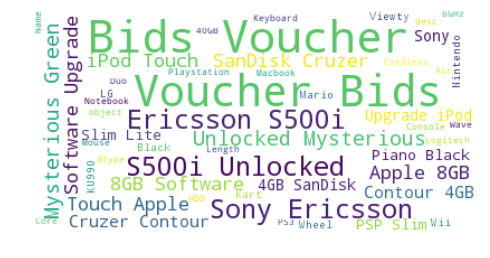

In [38]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(outcomesDf['desc']))

print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(8,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

A lot of the products that are auctioned contain the words "voucher" or "bids" in their product description. That is because certain items come along (or directly are in some cases) bids or cash that can be later used by the winnner in other Swoopo auctions.

In [39]:
print(outcomesDf['desc'][outcomesDf['desc'].str.contains("Bids")].unique())

['50 FreeBids Voucher' '300 FreeBids Voucher' '50 Bids Voucher'
 '300 Bids Voucher' '20 Bids Voucher'
 'Nintendo DSi Console (Black) + 50 Bids Voucher'
 'Nintendo DSi Console (Blue) + 50 Bids Voucher' '75 Bids Voucher'
 'Canon EOS Rebel T1i with 18-55mm lens + 150 Bids'
 'Sony PlayStation 3 Slim 120GB + 50 Bids'
 'Nikon D90 with 18-105mm Kit + 150 Bids'
 'Apple MacBook Pro 13.3" + 200 Bids' 'Nokia N97 + 150 Bids'
 'Sony PS3 160GB with Uncharted + 50 Bids'
 'Canon EOS Rebel T1i + 18-55mm + 150 FreeBids'
 'Nikon D90 with 18-105mm Kit + 150 FreeBids'
 'Sony PlayStation 3 Slim 250GB + 50 Bids'
 'Sony PlayStation 3 Slim 250GB + 50 FreeBids'
 'Apple MacBook Pro 13.3" + 200 FreeBids'
 'Apple iPhone 3GS 32GB Black+ 150 Bids'
 'Apple iPhone 3GS 32GB Black + 150 FreeBids'
 'Sony PS3 160GB with Uncharted + 50 FreeBids'
 'Apple iPhone 3GS 32GB Black + 200 FreeBids']


In [40]:
print(outcomesDf['desc'][outcomesDf['desc'].str.contains("Voucher")].unique())

['50 FreeBids Voucher' '300 FreeBids Voucher' '$15 Florist Voucher'
 '$30 Florist Voucher' '50 Bids Voucher' '300 Bids Voucher'
 '20 Bids Voucher' 'Nintendo DSi Console (Black) + 50 Bids Voucher'
 'Nintendo DSi Console (Blue) + 50 Bids Voucher' '75 Bids Voucher']


The top 10 winners and the number of auctions that each one won during the time period of the dataset are:

In [41]:
winners = outcomesDf.groupby(outcomesDf['winner'])['winner'].count()
winners.sort_values(ascending=False).head(10)

winner
HH0812         131
Oglalasioux    117
Toertchen      116
Koboldwicht    111
Schlumpf01     111
Kavvamartin    110
Thomsen321     109
Brusher        108
Aluf412        108
Trixi101       106
Name: winner, dtype: int64

As it has previosly been mentioned, the dataset contains auctions that ended within 2008-08-20 and 2009-12-12

In [42]:
print(min(outcomesDf['endtime_str']))
print(max(outcomesDf['endtime_str']))

2008-08-20 14:04:00
2009-12-12 15:10:00


In the next figure, the number of bids placed per month is represented. The reason why the number of bids placed in August 2008 and December 2009 is low is because the dataset does not contain data for all days of these months.
In general, it can be observed that November, December and January seem to be the months in which more bids are placed.

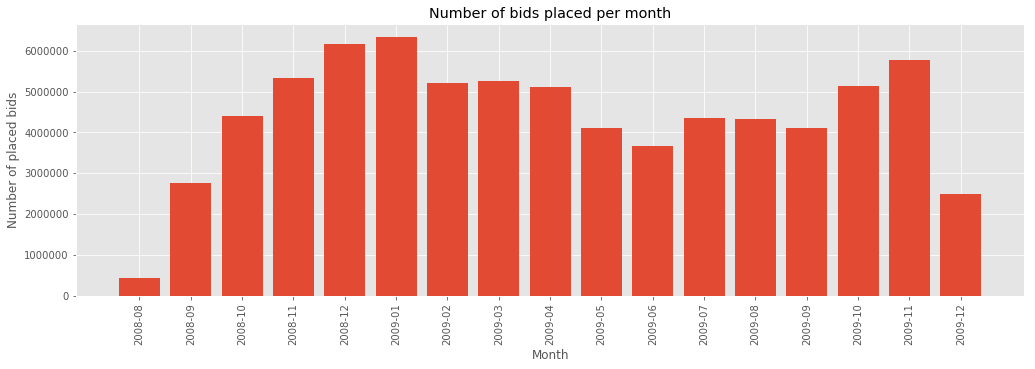

In [43]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.xlabel('Month')
plt.ylabel('Number of placed bids')
plt.title('Number of bids placed per month')
plt.show()

Considering the months for which we have the full data both in 2008 and 2009 (September, October and November), it can be seen that, in average, the number of bids placed has increased approximately a 25% in 2009 compared to 2008. These indicates that Swoopo gained popularity over the course of that year.

In [44]:
september2008Index = 1
october2008Index = 2
november2008Index = 3

september20092008NumberOfBidsDiff = (X[september2008Index+12] - X[september2008Index])/X[september2008Index]
october20092008NumberOfBidsDiff = (X[october2008Index+12] - X[october2008Index])/X[october2008Index]
november20092008NumberOfBidsDiff = (X[november2008Index+12] - X[november2008Index])/X[november2008Index]
meanYearlyIncreaseNumberOfBids = np.mean([september20092008NumberOfBidsDiff,october20092008NumberOfBidsDiff,november20092008NumberOfBidsDiff])
print(meanYearlyIncreaseNumberOfBids*100)

24.7388170363


Nevertheless, if the same calculation is performed for the profit obtained by Swoopo over the retail price of the items instead of the number of bids placed...

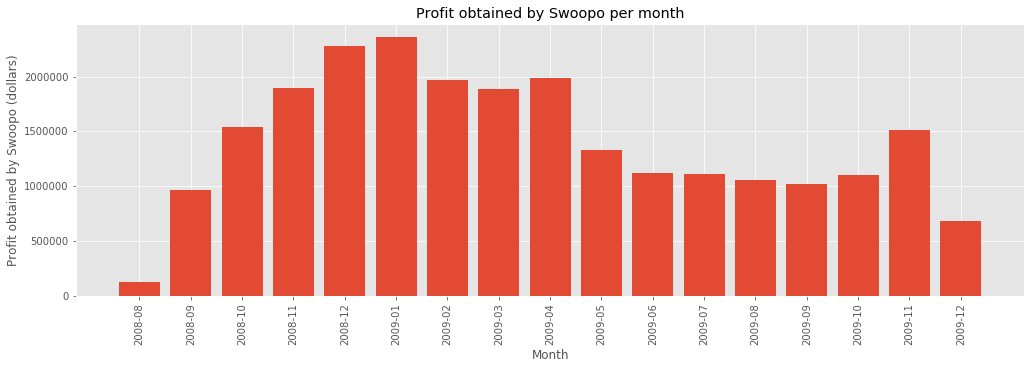

In [45]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.xlabel('Month')
plt.ylabel('Profit obtained by Swoopo (dollars)')
plt.title('Profit obtained by Swoopo per month')
plt.show()

september2008Index = 1
october2008Index = 2
november2008Index = 3

september20092008SwoopoProfitDiff = (X[september2008Index+12] - X[september2008Index])/X[september2008Index]
october20092008SwoopoProfitDiff = (X[october2008Index+12] - X[october2008Index])/X[october2008Index]
november20092008SwoopoProfitDiff = (X[november2008Index+12] - X[november2008Index])/X[november2008Index]
meanYearlyIncreaseSwoopoProfit = np.mean([september20092008SwoopoProfitDiff,october20092008SwoopoProfitDiff,november20092008SwoopoProfitDiff])

... it can be seen that, in average, the profit obtained has decreased approximately a 14.5% in 2009 compared to 2008.

In [46]:
print(meanYearlyIncreaseSwoopoProfit*100)

-14.4720849398


The following figure represents the sum of the retail price of the items auctioned monthly as well as the monthly sum of Swoopo's selling prices (calculated as the profit obtained over the retail price of the items plus their retail price).

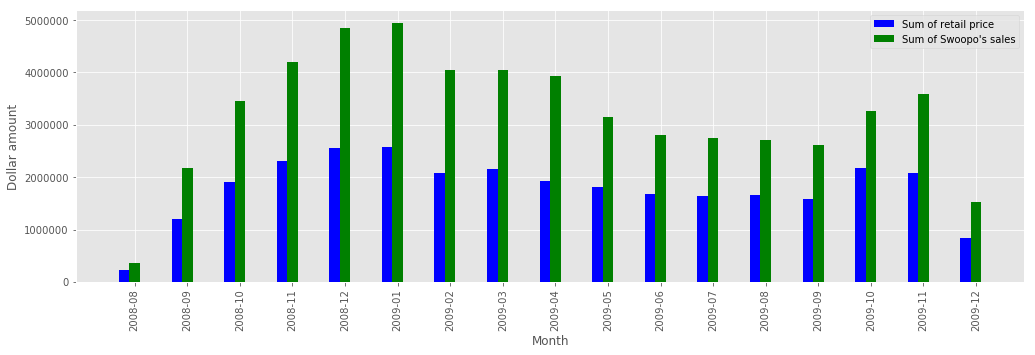

In [47]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.xlabel('Month')
plt.ylabel('Dollar amount')
plt.show()

The protit ratio (calculated as the revenue divided by the retail price) is greater than 1.00 every month.

In [48]:
profitRatio = (Y2+Y)/Y
profitRatio

array([ 1.5581843 ,  1.80897962,  1.80403348,  1.81773936,  1.89059953,
        1.91361918,  1.94733017,  1.87027243,  2.02653824,  1.73699862,
        1.66961902,  1.68107523,  1.63396903,  1.64282709,  1.50561787,
        1.72848257,  1.81697201])

The following figure represents the monthly profit ratio. The green line is the average profit ratio:

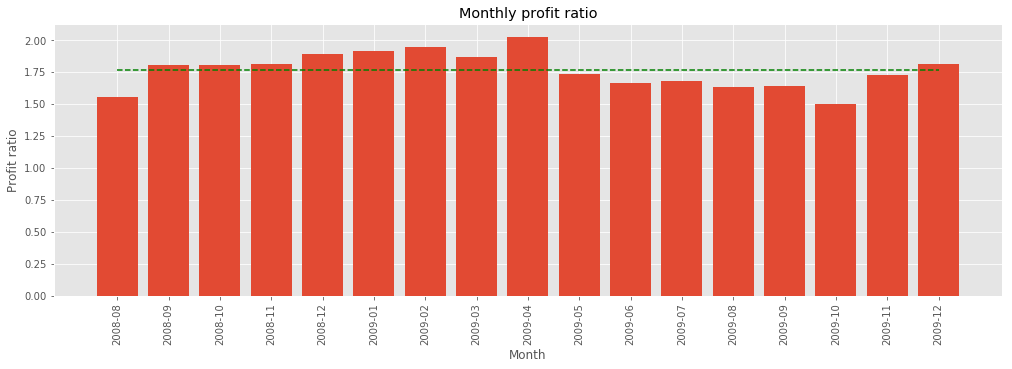

In [49]:
plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatio)), profitRatio)
plt.xticks(np.arange(len(profitRatio)), X,rotation='vertical')
mean_line = plt.plot(np.arange(len(X)),[np.mean(profitRatio)]*len(X), label='Mean', linestyle='--',color='g')
plt.xlabel('Month')
plt.ylabel('Profit ratio')
plt.title('Monthly profit ratio')
plt.show()

On average, the profit ratio is 76.8% (where 0% would mean no profit obtained at all):

In [50]:
np.mean(profitRatio)

1.767815161396

The time in which the profit is lower corresponds to the period of time between June 2009 and October 2009 (as it can also be seen in the figure above):

In [51]:
profitRatio,X= zip(*sorted(zip(profitRatio,X)))
for i in range(0,10):
    print (str(X[i])+ " : "+str(profitRatio[i]))

2009-10 : 1.50561787421
2008-08 : 1.55818429741
2009-08 : 1.63396903062
2009-09 : 1.64282709419
2009-06 : 1.66961902034
2009-07 : 1.68107523072
2009-11 : 1.72848257013
2009-05 : 1.73699862311
2008-10 : 1.80403347881
2008-09 : 1.80897962382


The following figure also represents the sum of the retail price of the items as well as the revenue obtained by Swoopo, but with weekly granularity instead of monthly granularity:

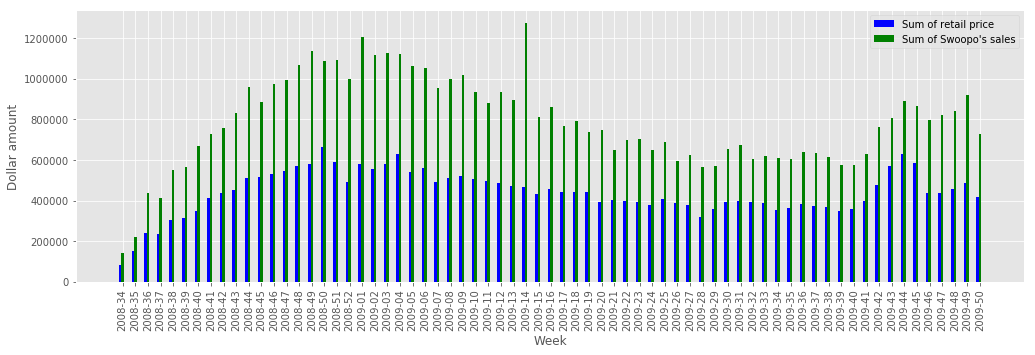

In [52]:
def timeStampToYearWeekFormat(timestamp):
    
    #for index_val, series_val in timeStampSeries.iteritems():
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        #Convert 2008-01 to 2009-01, because some days of the last week of 
        #a year are considered to be in the first week of the next year, 
        #and the data timestamps range from '2008-08-20 14:04:00' to '2009-12-12 15:10:00'
        #The ISO 8601 definition for week 01 is the week with the year's first Thursday in it.
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.xlabel('Week')
plt.ylabel('Dollar amount')
plt.show()

The profit ratio has also been calculated weekly, and it can be used to understand the periods that are best for Swoopo's business in terms of profit.

During the last two weeks of a year (2008/51 - 2008/52) plus the three first weeks of the next year (2009/01 - 2008/03) the profit obtained is higher than average, with its peak in the first week of the new year. Week 2009/14 (corresponding to the period from March 30, 2009 to April 5, 2009) is the week in which the highest profit is obtained with a very noticiable difference. The period between weeks 2009/29 - 2009/45 (July 13, 2009 - November 8, 2009) the profit obtained is lower than average.

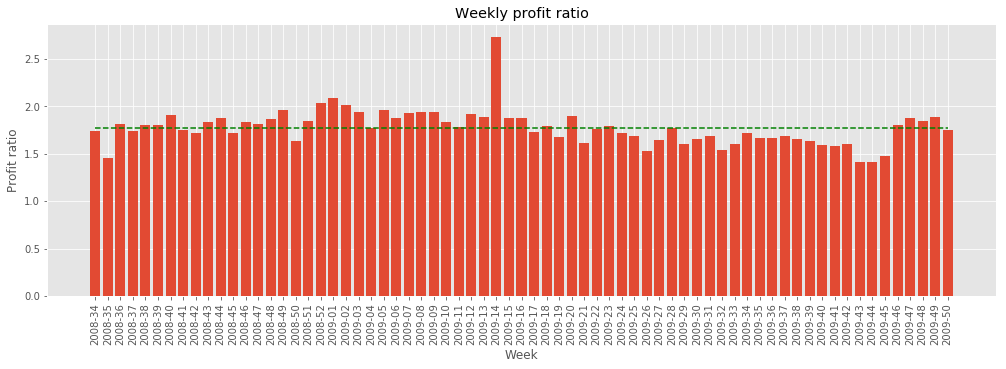

In [53]:
profitRatio = (Y2+Y)/Y
plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatio)), profitRatio)
plt.xticks(np.arange(len(profitRatio)), X,rotation='vertical')
mean_line = plt.plot(np.arange(len(X)),[np.mean(profitRatio)]*len(X), label='Mean', linestyle='--',color='g')
plt.xlabel('Week')
plt.ylabel('Profit ratio')
plt.title('Weekly profit ratio')
plt.show()

Finally, the daily profit ratio has been calculated to observe how holidays influence Swoopo's business in terms of profit. The z-score of the profit ratio has been calculated to compare the number of standard deviations that the profit ratio is away from its mean value each day.

In [54]:
f = lambda x: str(x)[:10]

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values

profitRatio = (Y2+Y)/Y
profitRatioZScore = (profitRatio - np.mean(profitRatio))/(np.std(profitRatio))
orderedX = X

profitRatioZScore,orderedX= zip(*sorted(zip(profitRatioZScore,orderedX),reverse=True))

Firstly, the highest 30 z-score values for the profit ratio within the dates contained in the dataset are shown. Several days of the week before 2009's New Year's Eve have high z-score values.  Also, the days between March 28, 2009 and April 6, 2009 have very high z-score values.

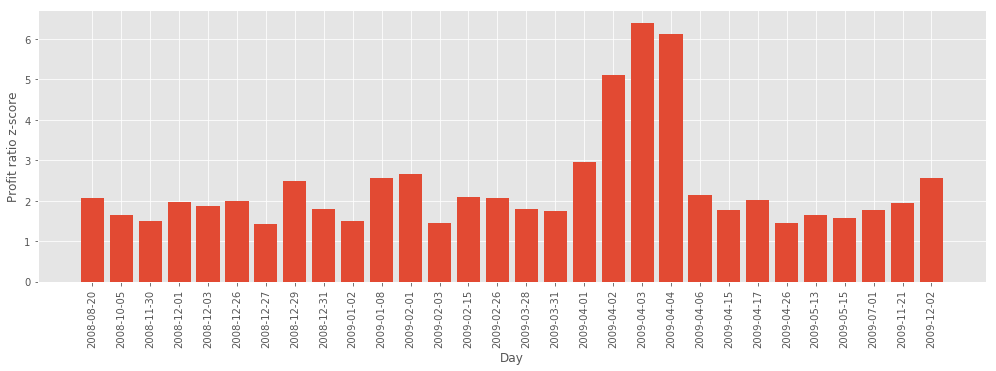

In [55]:
profitRatioZScoreTop30 = profitRatioZScore[0:30]
orderedXTop30 = orderedX[0:30]

orderedXTop30,profitRatioZScoreTop30= zip(*sorted(zip(orderedXTop30,profitRatioZScoreTop30)))

plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatioZScoreTop30)), profitRatioZScoreTop30)
plt.xticks(np.arange(len(profitRatioZScoreTop30)), orderedXTop30,rotation='vertical')
plt.xlabel('Day')
plt.ylabel('Profit ratio z-score')
plt.show()

Secondly, the lowest 30 z-score values for the profit ratio within the dates contained in the dataset are shown. June, July, August and October are the months in which more low z-score values can be found.

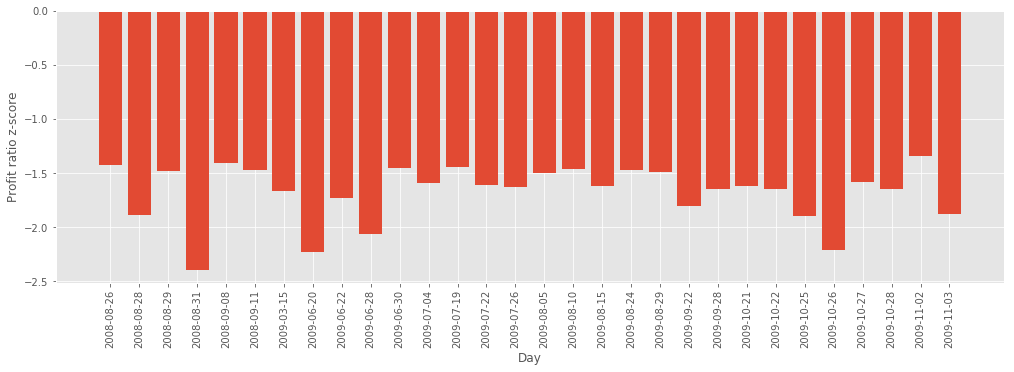

In [56]:
profitRatioZScore,orderedX= zip(*sorted(zip(profitRatioZScore,orderedX),reverse=False))
profitRatioZScore

profitRatioZScoreWorse30 = profitRatioZScore[0:30]
orderedXWorse30 = orderedX[0:30]

orderedXWorse30,profitRatioZScoreWorse30= zip(*sorted(zip(orderedXWorse30,profitRatioZScoreWorse30)))

plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatioZScoreWorse30)), profitRatioZScoreWorse30)
plt.xticks(np.arange(len(profitRatioZScoreWorse30)), orderedXWorse30,rotation='vertical')
plt.xlabel('Day')
plt.ylabel('Profit ratio z-score')
plt.show()

Now, the profit ratio for special dates is analyzed. These include the federal holidays in the USA, Black Friday, the week before Valentine's Day, and Christmas' season (December).

In [57]:
federalPublicHolidaysUSA2008 = ['2008-01-01','2008-01-21','2008-02-18','2008-05-26','2008-07-04','2008-09-01','2008-10-13','2008-11-11','2008-11-27','2008-11-28','2008-12-25']
federalPublicHolidaysUSA2009 = ['2009-01-01','2009-01-19','2009-02-16','2009-05-25','2009-07-03','2009-09-07','2009-10-12','2009-11-11','2009-11-26','2009-11-27','2009-12-25']
blackFriday2008 = ['2008-11-28']
blackFriday2009 = ['2009-11-27']
valentinesDay2008Season = ['2008-02-07','2008-02-08','2008-02-09','2008-02-10','2008-02-11','2008-02-12','2008-02-13','2008-02-14']
valentinesDay2009Season = ['2009-02-07','2009-02-08','2009-02-09','2009-02-10','2009-02-11','2009-02-12','2009-02-13','2009-02-14']

christmas2008Season = []
christmas2009Season = []
for i in range (1,32):
    dayString = '%02d' % i
    christmas2008Season.append('2008-12-'+dayString)
    christmas2009Season.append('2009-12-'+dayString)

In [58]:
orderedX,profitRatioZScore= zip(*sorted(zip(orderedX,profitRatioZScore)))
holidayTypeToProfitRatioZScore = {}

for i in range(0,len(orderedX)):
    dateToAnalyzeString = str(orderedX[i])
    isFederalPublicHolidayUSA2008 =  dateToAnalyzeString in federalPublicHolidaysUSA2008
    isFederalPublicHolidayUSA2009 = dateToAnalyzeString in federalPublicHolidaysUSA2009
    isFederalPublicHolidayUSA = isFederalPublicHolidayUSA2008 or isFederalPublicHolidayUSA2009
    
    isBlackFriday2008 = dateToAnalyzeString in blackFriday2008
    isBlackFriday2009 = dateToAnalyzeString in blackFriday2009
    isBlackFriday = isBlackFriday2008 or isBlackFriday2009
    
    isValentinesDay2008Season = dateToAnalyzeString in valentinesDay2008Season
    isValentinesDay2009Season = dateToAnalyzeString in valentinesDay2009Season
    isValentinesDaySeason = isValentinesDay2008Season or isValentinesDay2009Season
    
    isChristmas2008Season = dateToAnalyzeString in christmas2008Season
    isChristmas2009Season = dateToAnalyzeString in christmas2009Season
    isChristmasSeason = isChristmas2008Season or isChristmas2009Season
    
    holidayType = []
    yearString = dateToAnalyzeString[0:4]
    
    if isFederalPublicHolidayUSA:
        holidayType.append("FederalPublicHolidayUSA")
    if isBlackFriday:
        holidayType.append("BlackFriday")
    if isValentinesDaySeason:
        holidayType.append("ValentinesDaySeason")
    if isChristmasSeason:
        holidayType.append("ChristmasSeason")
    
    if holidayType:
        for holiday in holidayType:       
            holidayTypePlusYearString = holiday + yearString
        
            if holidayTypePlusYearString in holidayTypeToProfitRatioZScore:
                holidayTypeProfitRatioZScore = holidayTypeToProfitRatioZScore[holidayTypePlusYearString]
                holidayTypeProfitRatioZScore.append((dateToAnalyzeString,profitRatioZScore[i]))
            else:
                holidayTypeToProfitRatioZScore[holidayTypePlusYearString] = [(dateToAnalyzeString,profitRatioZScore[i])]

Black Friday has a positive z-score both in 2008 and 2009. Christmas' season (December) has days with both positive and negative z-score values (also, there is no complete data for December 2009). With the available data for December 2008, it can be concluded that the z-score is generally positive during the second half of December, with the highest values towards the end of the month. Public holidays have both positive and negative z-score values. The last days before 2009 Valentine's Day have positive z-score values.

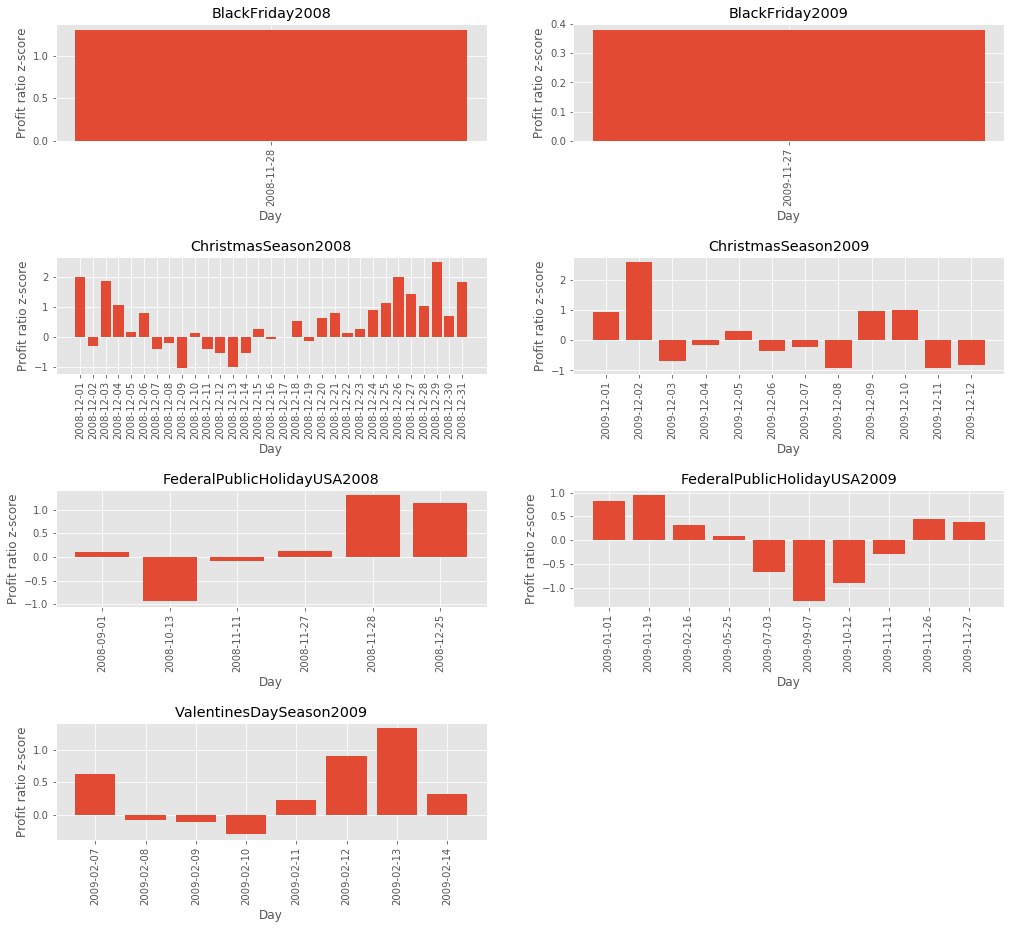

In [59]:
subplotIndex = 1

plt.figure(figsize=(17,15))  

for key in sorted(holidayTypeToProfitRatioZScore.keys()):
    value = holidayTypeToProfitRatioZScore[key]
    plt.subplot(4,2,subplotIndex)
    plt.title(key)
    
    X = [tupleElement[0] for tupleElement in value]
    Y = [tupleElement[1] for tupleElement in value]
    plt.bar(range(len(Y)), Y)
    plt.xticks(np.arange(len(Y)), X,rotation='vertical')
    plt.xlabel('Day')
    plt.ylabel('Profit ratio z-score')
    subplotIndex = subplotIndex +1
    
plt.subplots_adjust(hspace = 1)
plt.show()

Now, it is analyzed whether the day of the week (Monday-Sunday) has any efect on Swoopo's profit. The following figure represents the sum of the retail price of the auctioned items as well as the revenue obtained by Swoopo (calculated as the profit obtained over the retail price of the items plus their retail price), where 0 corresponds to Monday and 6 corresponds to Sunday.

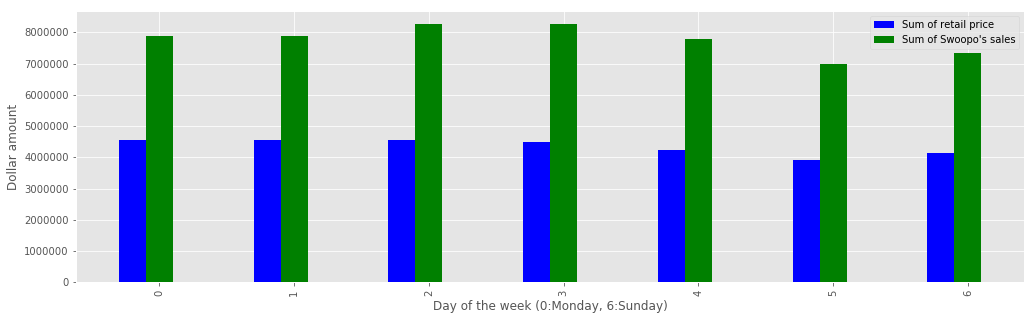

In [60]:
f = lambda x: str(x.dayofweek)

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.xlabel('Day of the week (0:Monday, 6:Sunday)')
plt.ylabel('Dollar amount')
plt.show()

The highest profit ratio is obtained on Friday, while the lowest positive ratio is obtained on Tuesday. Nevertheless, the values are pretty similar throughout all days of the week.

In [61]:
profitRatio = (Y2+Y)/Y
profitRatio,X= zip(*sorted(zip(profitRatio,X)))
for i in range(0,7):
    print (str(X[i])+ " : "+str(profitRatio[i]))

1 : 1.72413805621
0 : 1.73523136263
6 : 1.77636968881
5 : 1.78002566708
2 : 1.8181767152
3 : 1.83550859175
4 : 1.84089359583


Since a cleaning process has been performed throught the code executed before, the final DataFrame is saved as a new file:

In [62]:
outcomesDf.to_csv('./outcomes_clean.tsv',sep='\t')

# traces.tsv

This file is based on traces of live auctions that the authors of the dataset recorded using  their own recording infrastructure. It comprises 7,352 auctions conducted between October 1, 2009 and December 12, 2009. The traces include detailed bidding information for each auction, specifically the time and the player associated with each bid.

The authors probed Swoopo at semi-regular time-intervals (more frequently near the end of the auction when bids are placed in rapid succession, less frequently near the beginning of the auction when bidding is sparse). When the countdown clock had less than 2 minutes left on it, they probed at the rate Swoopo suggested but at least once every second (every probe response was associated with a Swoopo defined update-interval that Swoopo uses to instruct the user’s browser when to update next).

The result of each probe was a list of up to ten tuples of the form (username,bidnumber), indicating the
players that placed a bid since the previous probe and the order in which they did so. In the cases the list included more that one tuple, the authors ascribed the same timestamp to all of those bids.

Swoopo optinally provides the use of BidButlers, which are automatic bidding agents that bid according to user-defined instructions. Users are able to define starting and ending price limits for which automated bids shall be placed, as well as the top number of bids that the BidButler is allowed to place. BidButlers place automated bids when the auction timer drops below 10 seconds

A limitation from the authors' probing methodolody arises when more then ten players bid between successive probes. In particular, this happened when more than ten players were using BidButlers. In these cases, Swoopo responded with just the ten latest bids.

More details about the methodology used by the authors to create the dataset can be found at:

Byers, J. W., Mitzenmacher, M., & Zervas, G. (2010, June). Information asymmetries in pay-per-bid auctions. In Proceedings of the 11th ACM conference on Electronic commerce (pp. 1-12). ACM.

The file traces.tsv included in the dataset contains the following columns:

- auction_id: unique numerical id for the auction

- bid_time: the date and time of each bid

- bid_ct: the value of the countdown clock (seconds) at the time the bid was reported to the researchers that recorded the traces.

- bid_number: the number of the bid placed in the auction in ascending order, starting with 1.

- bid_user: the username of the bidder

- bid_butler: 1 for BidButler bids, 0 otherwise

- bid_cp: the price of the item after the bid was placed

- bid_user_secs_added: the number of seconds added to the countdown clock as a result non-BidButler bidded in the bid group (*)

- bid_butler_secs_added: the number of seconds added to the countdown clock as
  a result BidButler bidded in the bid group (*)

- bid_infered: 0 for the final bid in a bid group, 1 otherwise (*)

- bid_group: bid group identifier (*). Bids that were reported as part of the same group will have the
  same group number.

- bid_final: 1 for the winning bid (the last one), 0 otherwise

The other parameters of the auction can be looked up in outcomes.tsv using the auction_id field.

(*) bid groups: Occassionaly, between successive probes, more than one bids
would have occured and would be reported together. The authors refer to this as a bid group.
All bids in a bid group have been ascribed the same timestamp.

In [63]:
tracesDf.head(2)

,auction_id,bid_time,bid_ct,bid_number,bid_user,bid_butler,bid_cp,bid_user_secs_added,bid_butler_secs_added,bid_infered,bid_group,bid_final
0,222387,2009-10-04 12:33:26,19913,1,Becker1990,0,12,0,0,0,0,0
1,222387,2009-10-04 14:28:14,13029,2,Gaynor66,0,24,4,0,0,1,0


The types of the values seem to be appropiate, except for the type of the "bid_time" column. It is better to convert this column to DateTime objects, so that it is possible to use DateTime functions afterwards.

In [64]:
tracesDf.dtypes

auction_id                int64
bid_time                 object
bid_ct                    int64
bid_number                int64
bid_user                 object
bid_butler                int64
bid_cp                    int64
bid_user_secs_added       int64
bid_butler_secs_added     int64
bid_infered               int64
bid_group                 int64
bid_final                 int64
dtype: object

In [65]:
tracesDf['bid_time'] = pd.to_datetime(tracesDf['bid_time'])

There are no empty values in the dataset file:

In [66]:
tracesDf.isnull().values.any()

False

The field "bid_cp", which indicates the price of the item after each bid is placed, is expressed in cents. A conversion to dollars has been applied:

In [67]:
tracesDf['bid_cp'] = tracesDf['bid_cp']/100

As an example, the first auction in the dataset has been analyzed.

In [68]:
tracesDfAuctionId222387 = tracesDf[tracesDf['auction_id'] == 222387]

The auctioned product was a Wii videogame. Its retail price was 64.12 \$, and it was won by the user 'Clubfan78'. It total, 151 bids were placed with a bid fee of 60 cents. The final price of the item was 18.12 \$. Therefore, Swoopo earned (1-0.0455) \* 0.60 * 151 + 18.12 = 104.6 \$, where the value (1-0.0455) is the approximation made at the beginning of this notebook for the ratio between free bids and paid bids in an auction.

The winner placed 50 bids in total. The flag 'flg_click_only' is set to 1, so it was a "NailBiter" auction (Swoopo auctions which do not permit the use of automated bids by a BidButler).

In [69]:
outcomesDf[outcomesDf['auction_id'] == 222387]

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,...,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,bids_placed,swoopo_sale_price,swoopo_profit,winner_benefit
99108,222387,10012342,guitar-hero-world-tour-guitar-kit-wii-,Guitar Hero World Tour Guitar Kit (Wii),64.12,18.12,18.12,0.12,0.6,Clubfan78,...,0,2009-10-04 10:17:00,1,0,0,0,151.0,104.594461,40.474461,16.0


In [70]:
tracesDfAuctionId222387.head(3)

,auction_id,bid_time,bid_ct,bid_number,bid_user,bid_butler,bid_cp,bid_user_secs_added,bid_butler_secs_added,bid_infered,bid_group,bid_final
0,222387,2009-10-04 12:33:26,19913,1,Becker1990,0,0.12,0,0,0,0,0
1,222387,2009-10-04 14:28:14,13029,2,Gaynor66,0,0.24,4,0,0,1,0
2,222387,2009-10-04 14:44:08,12079,3,Jostrem16,0,0.36,4,0,0,2,0


In [71]:
tracesDfAuctionId222387.tail(3)

,auction_id,bid_time,bid_ct,bid_number,bid_user,bid_butler,bid_cp,bid_user_secs_added,bid_butler_secs_added,bid_infered,bid_group,bid_final
148,222387,2009-10-04 18:16:56,15,149,Clubfan78,0,17.88,1,0,0,138,0
149,222387,2009-10-04 18:17:00,15,150,Pjhuzz7579,0,18.00,2,0,0,139,0
150,222387,2009-10-04 18:17:06,15,151,Clubfan78,0,18.12,5,0,0,140,1


The auction lasted for 5 hours, 43 minutes and 40 seconds:

In [72]:
beginningTime = min(tracesDfAuctionId222387["bid_time"])
endingTime = max(tracesDfAuctionId222387["bid_time"])
print("Beggining time: " + str(beginningTime))
print("Ending time: "+ str(endingTime))
print("Total duration: "+ str(endingTime-beginningTime))

Beggining time: 2009-10-04 12:33:26
Ending time: 2009-10-04 18:17:06
Total duration: 0 days 05:43:40


The next figure represents the value of the countdown clock over time. When a bid is placed and the countdown clock is about to end, that bid increments the value of the countdown clock a few seconds, so theoretically, auctions could last infinitely. The objective of this method is to avoid users placing bids only a few seconds before the auction finishes.

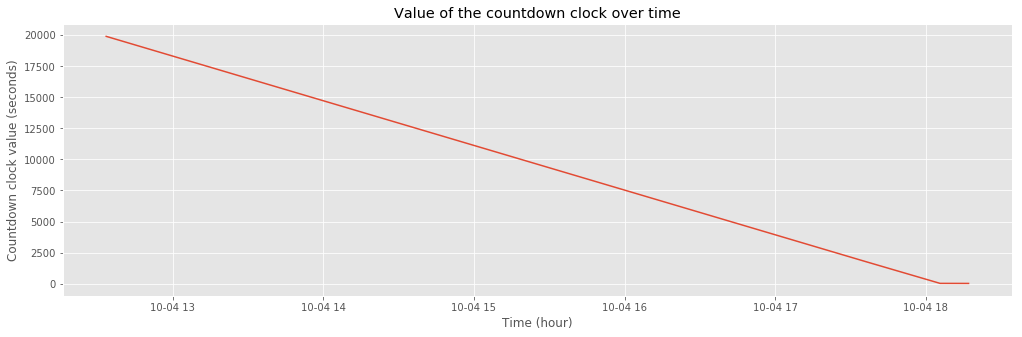

In [73]:
plt.figure(figsize=(17,5))
plt.plot(tracesDfAuctionId222387['bid_time'],tracesDfAuctionId222387['bid_ct'])
plt.xlabel('Time (hour)')
plt.ylabel('Countdown clock value (seconds)')
plt.title('Value of the countdown clock over time')
plt.show()

For the 8th bid, the value of the countdown clock is 20 seconds. For the next consecutive bids, the value of the countdown clock is also 20 seconds, since each one of those bdis is placed a few seconds after the last one and increments the value of the countdown clock back to that value:

In [74]:
tracesDfAuctionId222387.head(15)

,auction_id,bid_time,bid_ct,bid_number,bid_user,bid_butler,bid_cp,bid_user_secs_added,bid_butler_secs_added,bid_infered,bid_group,bid_final
0,222387,2009-10-04 12:33:26,19913,1,Becker1990,0,0.12,0,0,0,0,0
1,222387,2009-10-04 14:28:14,13029,2,Gaynor66,0,0.24,4,0,0,1,0
2,222387,2009-10-04 14:44:08,12079,3,Jostrem16,0,0.36,4,0,0,2,0
3,222387,2009-10-04 17:14:26,3071,4,Clubfan78,0,0.48,10,0,0,3,0
4,222387,2009-10-04 17:36:06,1773,5,Momstired2,0,0.60,2,0,0,4,0
5,222387,2009-10-04 17:58:02,476,6,Heiligsblech,0,0.72,19,0,0,5,0
6,222387,2009-10-04 18:05:18,40,7,Clubfan78,0,0.84,1,0,0,6,0
7,222387,2009-10-04 18:05:40,20,8,Buildergirl,0,0.96,1,0,0,7,0
8,222387,2009-10-04 18:05:44,20,9,Clubfan78,0,1.08,2,0,0,8,0
9,222387,2009-10-04 18:06:02,20,10,Ammoniac,0,1.20,18,0,0,9,0


Since the majority of the bids were placed when the countdown clock had a low value, it has been decided to analyze the bids that were placed after the countdown clock reached the value of 20 seconds for the first time.

Each point in the following figure represents a bid that was placed. The X axis represents the number of seconds left (with a negative value to see the figure from left to right) before the auction ends (at value 0). The Y value represents the value of the countdown clock.

As it can be seen, the majority of the bids that were placed made the countdown clock reset its value back to 20 seconds. Then, the value went down to 15 seconds until the last bid that was placed (by the winner).

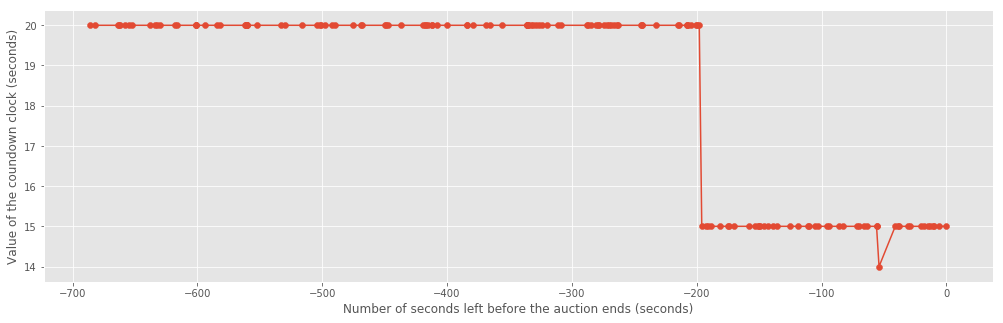

In [75]:
tracesDfAuctionId222387CountDown20 = tracesDfAuctionId222387[tracesDfAuctionId222387['bid_ct']<=20]
secondsToEndAndCountDownClockValue = (endingTime-tracesDfAuctionId222387CountDown20['bid_time']).apply(lambda x : -x.seconds)
plt.figure(figsize=(17,5))
plt.plot(secondsToEndAndCountDownClockValue,tracesDfAuctionId222387CountDown20['bid_ct'])
plt.scatter(secondsToEndAndCountDownClockValue,tracesDfAuctionId222387CountDown20['bid_ct'])
plt.xlabel('Number of seconds left before the auction ends (seconds)')
plt.ylabel('Value of the coundown clock (seconds)')
plt.show()

Generally, when the auction is about to end, a few users place auctions consecutively until one of them decides to keep bidding while the others do not.

As an example, the next figure represents the last bids that were placed (the ones for which the value of the countdown clock was 15 seconds), and the colors of the points represent the users that placed the bids. In the end, the auction becomes a "battle" between user "Pjhuzz7579" and user "Clubfan78" (who ends up winning the auction).

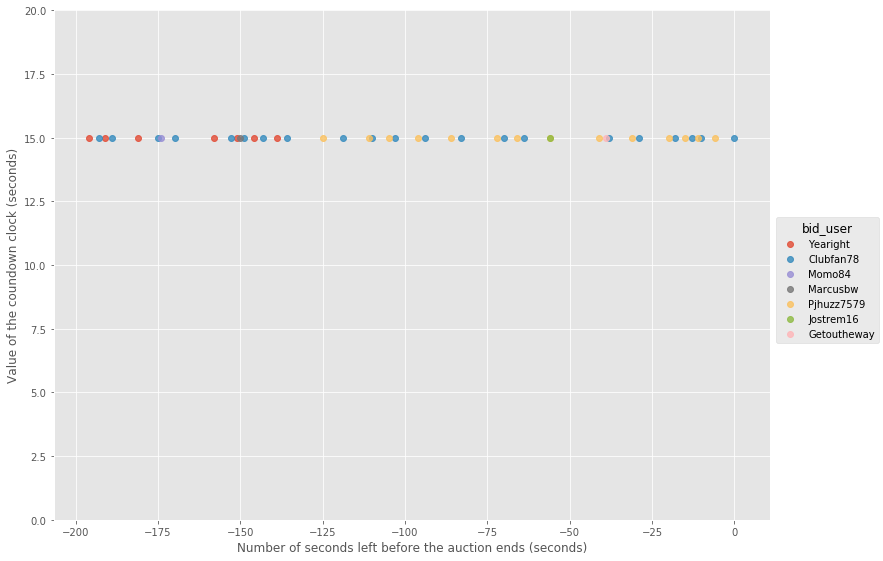

In [76]:
import seaborn as sns

tracesDfAuctionId222387CountDown15 = tracesDfAuctionId222387[tracesDfAuctionId222387['bid_ct']==15]
secondsToEndAndCountDownClockValue = (endingTime-tracesDfAuctionId222387CountDown15['bid_time']).apply(lambda x : -x.seconds)

plotDf = pd.DataFrame(dict(number_of_seconds_left=secondsToEndAndCountDownClockValue, countdown_clock_value=tracesDfAuctionId222387CountDown15['bid_ct'], bid_user=tracesDfAuctionId222387CountDown15['bid_user']))
plt.figure(figsize=(17,5))
sns.lmplot('number_of_seconds_left', 'countdown_clock_value', data=plotDf, hue='bid_user', fit_reg=False,size=8,aspect=1.4)
plt.xlabel('Number of seconds left before the auction ends (seconds)')
plt.ylabel('Value of the coundown clock (seconds)')
plt.ylim((0, 20))
plt.show()

In [77]:
tracesDfAuctionId222387.tail(10)[['bid_time','bid_number','bid_user']]

,bid_time,bid_number,bid_user
141,2009-10-04 18:16:35,142,Pjhuzz7579
142,2009-10-04 18:16:37,143,Clubfan78
143,2009-10-04 18:16:46,144,Pjhuzz7579
144,2009-10-04 18:16:48,145,Clubfan78
145,2009-10-04 18:16:51,146,Pjhuzz7579
146,2009-10-04 18:16:53,147,Clubfan78
147,2009-10-04 18:16:55,148,Pjhuzz7579
148,2009-10-04 18:16:56,149,Clubfan78
149,2009-10-04 18:17:00,150,Pjhuzz7579
150,2009-10-04 18:17:06,151,Clubfan78


Now, we proceed to analyze all of the traces contained in the dataset.

In [78]:
tracesGroupByAuctionIdDf = tracesDf.groupby(by='auction_id')

The average auction duration (calculated as the time that passed between the first bid and the last bid placed for that auction) is 7 hours and 10 minutes:

In [79]:
tracesAuctionDuration = (tracesGroupByAuctionIdDf['bid_time']).apply(lambda x: max(x)-min(x))
np.mean(tracesAuctionDuration)

Timedelta('0 days 07:10:20.507819')

Some users changed their username during the time that the auction traces were recorded, while others used their phone to place bids, and their phone number was the username recorded in the traces.

As an example, the last trace recorded for auction_id = 243299, corresponds to the user "Thedduell".

In [80]:
tracesDf[tracesDf['auction_id']==243299].tail(1)

,auction_id,bid_time,bid_ct,bid_number,bid_user,bid_butler,bid_cp,bid_user_secs_added,bid_butler_secs_added,bid_infered,bid_group,bid_final
1300456,243299,2009-11-13 19:29:08,0,393,Thedduell,1,47.16,1,2,0,182,1


However, in the public information provided by Swoopo about all auction results, the winner's username is "TheDuelMaster".

In [81]:
outcomesDf[outcomesDf['auction_id']==243299]

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,...,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,bids_placed,swoopo_sale_price,swoopo_profit,winner_benefit
113206,243299,10006485,wii-nintendo-console-wii-sports,Wii | Nintendo Console + Wii Sports,199.99,47.16,47.16,0.12,0.6,TheDuelMaster,...,0,2009-11-13 11:28:00,0,0,0,0,393.0,272.22267,72.23267,93.43


The last time that traces for the username "Thedduell" were recorded was on 2009-11-13 19:29:08. The first time that traces for the username "TheDuelMaster" were recorded was on 2009-11-26 20:25:55. Therefore, this user must have changed his or her username during this period of time, and Swoopo's public information must show the last username.

In [82]:
#old username
print(max(tracesDf[tracesDf['bid_user']=='Thedduell']['bid_time']))

#new username
print(min(tracesDf[tracesDf['bid_user']=='TheDuelMaster']['bid_time']))

2009-11-13 19:29:08
2009-11-26 20:25:55


Every other case such as this one (in which the winner's username recorded in the traces is different than to the one published by Swoopo for that auction) has been identified. The usernames appearing in the traces have been modified to match the ones publicly shared by Swoopo.

In [83]:
tracesDf['bid_user'] = tracesDf['bid_user'].replace('JEi66', 'Ei66')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Gibaufjunge', 'GeRi49')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+4925729233XXX', '4925729233XXX')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Brappa', 'ChancyBid')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Sieselber', 'JeGe87')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Real Deal', 'Deal')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('PitBull 01', '01')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Xzhuang', 'davis95618')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Holzfer89', 'ller89')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('dinoo', '1000freeb1ds')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Lakeboy956', 'slmktv')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Thedduell', 'TheDuelMaster')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+442071991XXX', 'Pagloo')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+442073214XXX', 'Pagloo')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+491774483XXX', 'Erkanimmer')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+441287201XXX', 'Darcireece')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+447949836XXX', 'Jules39')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Dooberdon', 'donoo')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+4953612211XXX', 'karim2002')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+494864XXX', 'Paddytiger')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+4977248807XXX', 'Panchoo')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Cjdumpty', 'dumpty')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('+4917624887XXX', '4917624887XXX')
tracesDf['bid_user'] = tracesDf['bid_user'].replace('Steve22256', 'Brusher2')

For each auction recorded in the traces, the following function is used to store the following information in a dictionary: 
- The auction id
- The mean time difference between all bids placed by the winner.
- The number of bids placed for each value of the countdown clock.
- The count of all of the bids placed in the auction, and the count of the bids that were placed by the winner.
- The count of all of the bids in the auction that were placed using Bid Butlers, and the count of the bids placed by the winner using a Bid Butler.
- Whether the winning bid was placed using a BidButler or not.
- The mean number of bids placed by the users that lost the auction.
- The mean time difference between the bids placed by the users that lost the auction.

In [84]:
def getTraceStatistics(auctionRows):
    auctionId = auctionRows['auction_id'].unique()[0]
    
    #winner publicly published by Swoopo 
    actualWinner = outcomesDf[outcomesDf['auction_id']==auctionId]['winner'].unique()[0]   
    #rows in the traces corresponding to the winner
    winnerUserRows = auctionRows[auctionRows['bid_user'] == actualWinner]
    #rows in the traces corresponding to the losers
    loserUsersRows = auctionRows[auctionRows['bid_user'] != actualWinner]
    
    isFirstRow = True
    lastBidTimeWinner = None
    lastBidIsBidButlerBid = False
    timeBetweenWinnerBids = []    
    counter = 0
    
    for index, row in winnerUserRows.iterrows():
        #iteration throughout all of the bids placed by the winner
        if isFirstRow:            
            isFirstRow = False
            #first bid
            lastBidTimeWinner = row['bid_time']
            if winnerUserRows.shape[0] == 1:
                #case in which the winner has placed a single bid
                
                #The time between bids is considered to be zero, and a
                #TimeDelta of value zero is stored as a placeholder
                #for the time difference between winner bids in this auction
                timeBetweenWinnerBids.append(lastBidTimeWinner-lastBidTimeWinner)
                if counter == winnerUserRows.shape[0]-1:
                    #last bid placed by the winner (i.e., winning bid)
                    if row['bid_butler'] == 1:
                        #last bid was placed using a Bid Butler
                        lastBidIsBidButlerBid = True
            counter += 1
            continue
            
        bidTime = row['bid_time']
        #time difference between the current bid and the last bid
        bidTimeDifference = bidTime - lastBidTimeWinner
        #time differences are stored in a list
        timeBetweenWinnerBids.append(bidTimeDifference)
        lastBidTimeWinner = row['bid_time'] 
        if counter == winnerUserRows.shape[0]-1:
            #last bid placed by the winner (i.e., winning bid)
            if row['bid_butler'] == 1:
                #last bid was placed using a Bid Butler
                lastBidIsBidButlerBid = True
        counter += 1

    #dictionary containing the username and bidding times for all the users that lost the auction
    loserUserNamesToBiddingTimes = {}   
    for index, row in loserUsersRows.iterrows():
        #iteration throughout all of the bids placed by the losers
        bidTime = row['bid_time']
        userName = row['bid_user']
        
        if userName in loserUserNamesToBiddingTimes:
            loserUserNamesToBiddingTimes[userName].append(bidTime)
        else:
            loserUserNamesToBiddingTimes[userName] = [bidTime]
    
    #list containing the number of bids that each user that lost the auction placed
    bidsPlacedPerLoserUser = []
    #list containing the mean time difference between the bids placed by the users
    #that lost the auction
    meanTimeDifferenceBetweenBidsPerLoserUser = []
    
    for userName, bidTimes in loserUserNamesToBiddingTimes.items():
        #number of bids placed by the user
        loserUserNameNumberOfBidsPlaced = len(bidTimes)
        bidsPlacedPerLoserUser.append(loserUserNameNumberOfBidsPlaced)
        
        timeDifferenceBetweenBids = []
        if loserUserNameNumberOfBidsPlaced > 1:
            #the time difference is calculated in the case that the user
            #placed more than one bid
            for index in range (1,len(bidTimes)):
                timeDifferenceBetweenBids.append(bidTimes[index]-bidTimes[index-1])
            
            #mean time difference    
            meanTimeDifferenceBetweenBids = np.mean(timeDifferenceBetweenBids)
            meanTimeDifferenceBetweenBidsPerLoserUser.append(meanTimeDifferenceBetweenBids)
    
    if not bidsPlacedPerLoserUser:
        #the only user that bidded in this auction was the user that won the auction.
        #in order to calculate the average, it is then indicated that the number of
        #bids placed by the losers is zero.
        bidsPlacedPerLoserUser.append(0)

    if not meanTimeDifferenceBetweenBidsPerLoserUser:
        #the only user that bidded in the auction was the user that won the auction,
        #or all of the other users only bidded once, so it was not possible to calculate
        #a time difference for their bids
        
        #TimeDelta of value zero is stored as a placeholder
        meanTimeDifferenceBetweenBidsPerLoserUser.append(pd.Timedelta('0 days 00:00:00'))      
    
    #mean number of bids placed by all losers
    meanNumberOfBidsPlacedPerLoserUsers = np.mean(bidsPlacedPerLoserUser)
    #mean time difference between all losers' bids
    meanOfMeanTimeDifferenceBetweenBidsPerLoserUsers = np.mean(meanTimeDifferenceBetweenBidsPerLoserUser)        
        
    if not timeBetweenWinnerBids:
        #line used to check that all winner usernames correspond to the same ones published by Swoopo
        #the list storing the time differences is empty when the DF winnerUserRows is empty (i.e., when
        #there are no traces with the username published by Swoopo as the auction winner)
        print('auctionID: '+ str(auctionId) +' : winner\'s username does not correspond to the one published by Swoopo')
    
    #Mean time difference between all bids placed by the winner.
    meanTimeBetweenWinnerBids = np.mean(timeBetweenWinnerBids)
    
    #Number of bids placed for each value of the countdown clock
    bidsPerCountdownClockValue = auctionRows.groupby(by='bid_ct')['bid_ct'].count()
    
    #Count of all bids placed in the auction, and count of bids placed by the winner
    totalBidsCount = auctionRows.shape[0]
    winnerBidsCount = winnerUserRows.shape[0]
   
    #Count of all bids placed with Bid Butlers in the auction, 
    #and count of bids placed by the winner using a Bid Butler
    totalBidButlerBidsCount = np.sum(auctionRows['bid_butler'])        
    winnerBidButlerBidsCount = np.sum(winnerUserRows['bid_butler'])    

    auctionIdTraceStatistics = {
        "auctionId" : auctionId,
        "meanTimeBetweenWinnerBids" : meanTimeBetweenWinnerBids,
        "bidsPerCountdownClockValue" : bidsPerCountdownClockValue,
        "totalBidsCount" : totalBidsCount,
        "winnerBidsCount" : winnerBidsCount,
        "totalBidButlerBidsCount" : totalBidButlerBidsCount,
        "winnerBidButlerBidsCount" : winnerBidButlerBidsCount,
        "lastBidIsBidButlerBid" : lastBidIsBidButlerBid,
        "meanNumberOfBidsPlacedPerLoserUsers" : meanNumberOfBidsPlacedPerLoserUsers,
        "meanOfMeanTimeDifferenceBetweenBidsPerLoserUsers" : meanOfMeanTimeDifferenceBetweenBidsPerLoserUsers 
    }
    
    return auctionIdTraceStatistics
 
#the function is called once per each different auction
auctionIdTraceStatistics = tracesGroupByAuctionIdDf.apply(getTraceStatistics)

The information is extracted from the dictionary and placed in different lists:

In [85]:
auctionIdList=[]
meanTimeBetweenWinnerBidsList=[]
bidsPerCountdownClockValueList=[]
totalBidsCountList=[]
winnerBidsCountList=[]
totalBidButlerBidsCountList=[]
winnerBidButlerBidsCountList=[]
lastBidIsBidButlerBidList=[]
meanNumberOfBidsPlacedPerLoserUsersList=[]
meanOfMeanTimeDifferenceBetweenBidsPerLoserUsersList=[]

for index, value in auctionIdTraceStatistics.iteritems():
    auctionIdList.append(value.get('auctionId'))
    meanTimeBetweenWinnerBidsList.append(value.get('meanTimeBetweenWinnerBids'))
    bidsPerCountdownClockValueList.append(value.get('bidsPerCountdownClockValue'))
    totalBidsCountList.append(value.get('totalBidsCount'))
    winnerBidsCountList.append(value.get('winnerBidsCount'))
    totalBidButlerBidsCountList.append(value.get('totalBidButlerBidsCount'))
    winnerBidButlerBidsCountList.append(value.get('winnerBidButlerBidsCount'))
    lastBidIsBidButlerBidList.append(value.get('lastBidIsBidButlerBid'))
    meanNumberOfBidsPlacedPerLoserUsersList.append(value.get('meanNumberOfBidsPlacedPerLoserUsers'))
    meanOfMeanTimeDifferenceBetweenBidsPerLoserUsersList.append(value.get('meanOfMeanTimeDifferenceBetweenBidsPerLoserUsers'))

The mean time difference between the bids placed by the winners is around 5 minutes, while the mean time difference between the bids placed by the losers is around 13 minutes.

In [86]:
#A TimeDelta of value zero might have been stored as a placeholder for some auctions,
#but it is not considered in the calculations
zeroTimeDelta = pd.Timedelta('0 days 00:00:00')

meanTimeBetweenWinnerBidsExcludingZeroTimeDeltasList = [x for x in meanTimeBetweenWinnerBidsList if x != zeroTimeDelta]
meanTimeBetweenWinnerBidsExcludingZeroTimeDeltas= np.mean(meanTimeBetweenWinnerBidsExcludingZeroTimeDeltasList)

meanTimeBetweenLoserBidsExcludingZeroTimeDeltasList = [x for x in meanOfMeanTimeDifferenceBetweenBidsPerLoserUsersList if x != zeroTimeDelta]
meanTimeBetweenLoserBidsExcludingZeroTimeDeltas = np.mean(meanTimeBetweenLoserBidsExcludingZeroTimeDeltasList)

print("Mean time difference between winner bids : "+ str(meanTimeBetweenWinnerBidsExcludingZeroTimeDeltas))
print("Mean time difference between loser bids : "+ str(meanTimeBetweenLoserBidsExcludingZeroTimeDeltas))

Mean time difference between winner bids : 0 days 00:04:52.667649
Mean time difference between loser bids : 0 days 00:12:49.368335


The number of bids placed is significantly different for different values of the countdown clock. This is because, when a bid is placed and the countdown clock is about to end, that bid increments the value of the countdown clock a few seconds, so that users do not place bids only a few seconds before the auction finishes.

In [87]:
bidsPerCountdownClockValueDictionary = {}
for singleAuctionBidsPerCountdownClockValue in bidsPerCountdownClockValueList:
    for index, value in singleAuctionBidsPerCountdownClockValue.iteritems():
        if index in bidsPerCountdownClockValueDictionary:
            bidsPerCountdownClockValueDictionary[index] += value
        else:
            bidsPerCountdownClockValueDictionary[index] = value

sortedBidsPerCountdownClockValue = sorted(bidsPerCountdownClockValueDictionary.items(), key=operator.itemgetter(1), reverse = True)
sortedBidsPerCountdownClockValue

countdownClockValueList = []
bidCountList = []
for countdownClockValue, bidCount in sortedBidsPerCountdownClockValue:
    countdownClockValueList.append(countdownClockValue)
    bidCountList.append(bidCount)

Most of the bids make the countdown clock restart its value to either 10 seconds (for bids placed when the countdown clock is displaying a value between 1 and 9 seconds), 15 seconds (for bids placed when the countdown clock is displaying a value between 11 and 14 seconds) or 20 seconds (for bids placed when the countdown clock is displaying a value between 16 and 19 seconds). This means that the majority of the bids are placed when the auction is supposedly (but not really) about to end, and the countdown clock has a very low value for a great part of the auction duration. This is a common practice in most pay-per-bid auction sites.

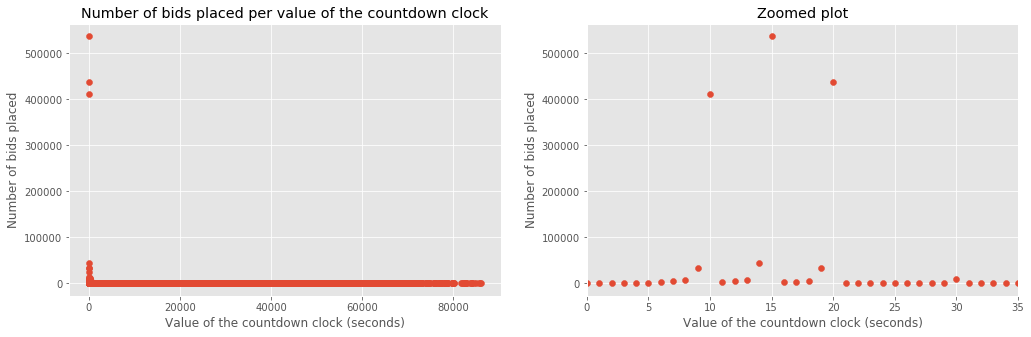

In [88]:
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.scatter(countdownClockValueList,bidCountList)
plt.xlabel('Value of the countdown clock (seconds)')
plt.ylabel('Number of bids placed')
plt.title('Number of bids placed per value of the countdown clock')
plt.subplot(122)
plt.scatter(countdownClockValueList,bidCountList)
plt.xlim((0, 35))
plt.xlabel('Value of the countdown clock (seconds)')
plt.ylabel('Number of bids placed')
plt.title('Zoomed plot')
plt.show()

In average, for the auctions recorded in the traces, the winner places about 20% of all of the bids placed in the auction. Winners place around 35 bids per auction, while losers place around 6 bids per auction. Consequently, winning an auction normally implies placing a large number of bids as well as placing more bids than the other participants.

As it has been mentioned before, Swoopo provides the user with the possibility of using Bid Butlers (automatic bidding agents that place automated bids according to user-defined restrictions when the auction timer drops below 10 seconds). In average, around 25% of all of the bids placed with Bid Butlers during a single auction are placed by the winner. Also, around 50% of all of the bids placed by winners are placed using Bid Butlers. Moreover, there is a change of around 33% that the last bid placed in an auction (i.e., the winning bid) was placed by a Bid Butler. Consequently, using Bid Butlers seems to be a good choice to win auctions.

In [89]:
percentageWinnerBidsOverTotalBidsList = []
percentageWinnerBidButlerBidsOverTotalBidButlerBidsList = []
percentageWinnerBitButlerBidsOverAllWinnerBidsList = []

for index in range(0,len(totalBidsCountList)):
    percentageWinnerBidsOverTotalBids = winnerBidsCountList[index]/totalBidsCountList[index]
    percentageWinnerBidsOverTotalBidsList.append(percentageWinnerBidsOverTotalBids)
    
    if totalBidButlerBidsCountList[index] == 0:
        continue
    percentageWinnerBidButlerBidsOverTotalBidButlerBids = winnerBidButlerBidsCountList[index]/totalBidButlerBidsCountList[index]
    percentageWinnerBidButlerBidsOverTotalBidButlerBidsList.append(percentageWinnerBidButlerBidsOverTotalBidButlerBids)
  
    percentageWinnerBitButlerBidsOverAllWinnerBidsList.append(winnerBidButlerBidsCountList[index]/winnerBidsCountList[index])

percentageWinnerBidsOverTotalBids = np.mean(percentageWinnerBidsOverTotalBidsList)
meanWinnerBidsCount = np.mean(winnerBidsCountList)
meanNumberOfBidsPlacedPerLoserUsersExcludingZerosList = [x for x in meanNumberOfBidsPlacedPerLoserUsersList if x != 0]
meanLoserBidsCount = np.mean(meanNumberOfBidsPlacedPerLoserUsersExcludingZerosList)
print('Percentage of winner bids over total bids : '+str(percentageWinnerBidsOverTotalBids))
print('Mean number of winner bids count : '+str(meanWinnerBidsCount))
print('Mean number of loser bids count : '+str(meanLoserBidsCount))

percentageWinnerBidButlerBidsOverTotalBidButlerBids = np.mean(percentageWinnerBidButlerBidsOverTotalBidButlerBidsList)
percentageWinnerBitButlerBidsOverAllWinnerBids = np.mean(percentageWinnerBitButlerBidsOverAllWinnerBidsList)
print('Percentage of winner Bid Butler bids over total Bit Butler bids: '+ str(percentageWinnerBidButlerBidsOverTotalBidButlerBids))
print('Percentage of winner Bid Butler bids over all winnner bids: '+ str(percentageWinnerBitButlerBidsOverAllWinnerBids))

probabilityLastBidIsBidButlerBid = np.mean(lastBidIsBidButlerBidList)
print('Probability that the last bid (winning bid) was placed by a Bid Butler : '+str(probabilityLastBidIsBidButlerBid))

Percentage of winner bids over total bids : 0.19000447411
Mean number of winner bids count : 34.3988848089
Mean number of loser bids count : 5.77949720439
Percentage of winner Bid Butler bids over total Bit Butler bids: 0.251864520599
Percentage of winner Bid Butler bids over all winnner bids: 0.527875798336
Probability that the last bid (winning bid) was placed by a Bid Butler : 0.313069495444


Nevertheless, for the auctions contained in the traces, the mean number of bids placed by the winners in the auctions that were won by placing the final bid with a Bid Butler is around 79 bids. The mean number of bids placed by the winners in the auctions that were NOT won by placing the final bid with a Bid Butler is much lower, around 28 bids. Therefore, although using Bid Butlers seems to be a good choice to win auctions, it generally implies placing a much larger number of bids.

In [90]:
lastBidIsBidButlerAuctionIdList=np.array(auctionIdList)[np.array(lastBidIsBidButlerBidList)]
lastBidIsNotBidButlerAuctionIdList=np.array(auctionIdList)[np.invert(np.array(lastBidIsBidButlerBidList))]

outcomesDfLastBidIsBidButlerAuctionIdList = outcomesDf[outcomesDf['auction_id'].isin(lastBidIsBidButlerAuctionIdList)]
outcomesDfLastBidIsNotBidButlerAuctionIdList = outcomesDf[outcomesDf['auction_id'].isin(lastBidIsNotBidButlerAuctionIdList)]
outcomesDfTracesAuctionList = outcomesDf[outcomesDf['auction_id'].isin(auctionIdList)]

lastBidIsBidButlerCountPaidWinnerBids = outcomesDfLastBidIsBidButlerAuctionIdList['placedbids']
lastBidIsBidButlerCountFreeWinnerBids = outcomesDfLastBidIsBidButlerAuctionIdList['freebids']
lastBidIsBidButlerCountWinnerBids = lastBidIsBidButlerCountPaidWinnerBids + lastBidIsBidButlerCountFreeWinnerBids
lastBidIsBidButlerMeanCountWinnerBids = np.mean(lastBidIsBidButlerCountWinnerBids)
print('Mean number of bids placed by winners for the recorded auctions that were won by a Bid Butler bid : '+str(lastBidIsBidButlerMeanCountWinnerBids))

lastBidIsNotBidButlerCountPaidWinnerBids = outcomesDfLastBidIsNotBidButlerAuctionIdList['placedbids']
lastBidIsNotBidButlerCountFreeWinnerBids = outcomesDfLastBidIsNotBidButlerAuctionIdList['freebids']
lastBidIsNotBidButlerCountWinnerBids = lastBidIsNotBidButlerCountPaidWinnerBids + lastBidIsNotBidButlerCountFreeWinnerBids
lastBidIsNotBidButlerMeanCountWinnerBids = np.mean(lastBidIsNotBidButlerCountWinnerBids)
print('Mean number of bids placed by winners for the recorded auctions that were won by a non-Bid Butler bid : '+str(lastBidIsNotBidButlerMeanCountWinnerBids))

Mean number of bids placed by winners for the recorded auctions that were won by a Bid Butler bid : 78.64769765421373
Mean number of bids placed by winners for the recorded auctions that were won by a non-Bid Butler bid : 28.307859829736685


For the auctions recorded in the traces, the mean profit obtained by Swoopo over the retail price of the items in the auctions that were won by placing he final bid with a Bid Butler is around 130 dollars. The mean profit obtained by Swoopo for the auctions that were NOT won by placing the final bid with a Bid Butler is much lower, around 64 dollars. Therefore, the fact that users choose to use Bid Butlers to win auctions is benefitial for Swoopo in terms of profit.

The mean profit obtained by Swoopo for all of the auctions contained in the traces is around 85 dollars. This value is much closer to the profit obtained for the auctions that were NOT won by placing the final bid with a Bid Butler, so this implies that most of the auctions are not won using a Bid Butler (as it has been mentioned before, the probability that the last bid (winning bid) was placed by a Bid Butler was around 33%).

In [91]:
meanSwoopoProfitLastBidIsBidButlerBid = np.mean(outcomesDfLastBidIsBidButlerAuctionIdList['swoopo_profit'])
meanSwoopoProfitLastBidIsNotBidButlerBid = np.mean(outcomesDfLastBidIsNotBidButlerAuctionIdList['swoopo_profit'])
meanSwoopoProfitAllTracedAuctions = np.mean(outcomesDfTracesAuctionList['swoopo_profit'])

print('Mean Swoopo profit for the auctions in the traces that were won by a Bid Butler bid : '+str(meanSwoopoProfitLastBidIsBidButlerBid))
print('Mean Swoopo profit for the auctions in the traces that were won by non-Bid Butler bid : '+str(meanSwoopoProfitLastBidIsNotBidButlerBid))
print('Mean Swoopo profit for all auctions in the traces : '+str(meanSwoopoProfitAllTracedAuctions))

Mean Swoopo profit for the auctions in the traces that were won by a Bid Butler bid : 130.40063889791293
Mean Swoopo profit for the auctions in the traces that were won by non-Bid Butler bid : 63.880038453393446
Mean Swoopo profit for all auctions in the traces : 84.70560927119375


Since a cleaning process has been performed throught the code executed before, the final DataFrame is saved as a new file:

In [92]:
outcomesDf.to_csv('./traces_clean.tsv',sep='\t')

In [93]:
cargar los dos DF limpios en todos los notebook

SyntaxError: invalid syntax (<ipython-input-93-cc17d9feaae9>, line 1)

In [ ]:
outcomesDfItemDesc =outcomesDf[['item','desc']]
outcomesDfItemDesc.head()
outcomesDfItemDesc.shape
itemColumnValueCounts = outcomesDf['item'].value_counts()
itemColumnValueCounts.head()
outcomesDfItemDesc.shape
outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc
descColumnValueCounts = outcomesDf['desc'].value_counts()
descColumnValueCounts.head()
outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc.head()
outcomesDfItemDesc[outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count']]['item'].unique()

In [ ]:
outcomesDfItemDesc[outcomesDfItemDesc['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam"]['desc'].unique()

In [ ]:
for itemdesc in outcomesDf['desc'].unique():
    print(itemdesc)

In [ ]:
productCategoriesDf = pd.read_excel('./product_categories.xlsx')
productCategoriesDf.head()

In [ ]:
outcomesDfWithCategory = outcomesDf.merge(productCategoriesDf[['desc','category']],how='left')
outcomesDfWithCategory.head()

In [ ]:
outcomesDfWithCategory[outcomesDfWithCategory.isnull().any(1)]

In [ ]:
productCategoriesDf[productCategoriesDf['item'] == 'perig-um-diamond-retrograde']

In [ ]:
productCategoriesDf.loc[productCategoriesDf['item'].values=="garmin-n-vi-250-3-5-inch-portable-gps-na", 'desc'] = "Garmin nüvi 250 3.5-Inch Portable GPS Navigator"
productCategoriesDf.loc[productCategoriesDf['item'].values=="krug-ba-men-regatta-diamond-mens-watch", 'desc'] = "Krug Baümen Regatta Diamond Mens Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-llandudno-ladies-watch", 'desc'] = "Perigáum Llandudno Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="pok-mon-ranger-shadows-of-almia-nintendo", 'desc'] = "Pokémon Ranger: Shadows of Almia (Nintendo DS)"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-florentia-ladies-watch", 'desc'] = "Perigáum Florentia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-leticia-ladies-watch", 'desc'] = "Perigáum Leticia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-saint-lucia-ladies-watch", 'desc'] = "Perigáum Saint Lucia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="samsung-ln40a630-40-inch-1080p-120hz-lcd", 'desc'] = "Samsung LN40A630 40-Inch 1080p 120Hz LCD HDTV"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-moonwalker-mens-luxury-watch", 'desc'] = "Perigáum Moonwalker Mens Luxury Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-fiona-ladies-watch", 'desc'] = "Perigáum Fiona Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-diamond-retrograde", 'desc'] = "Perigáum Diamond Retrograde"


In [ ]:
outcomesDf['winner'].value_counts()

In [ ]:
outcomesDf['desc'].value_counts()

In [ ]:
outcomesDf.head()

In [ ]:
outcomesDf['bidincrement'] = outcomesDf['bidincrement']/100
outcomesDf['bidfee'] = outcomesDf['bidfee']/100

In [ ]:
outcomesDf['finalprice_withbids'] = outcomesDf['finalprice'] + outcomesDf['placedbids']*outcomesDf['bidfee']/100

In [ ]:
X = outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
y = outcomesDf["finalprice"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rmodel=RandomForestRegressor()
rmodel.fit(X,y)
outcomesDf['P_finalprice'] = rmodel.predict(outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(outcomesDf["finalprice"],outcomesDf["P_finalprice"])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=14)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor

In [ ]:
red = decomposition.PCA()
clf = RandomForestRegressor()
pipe = Pipeline(steps=[('pca', red), ('Random Forest',clf)])
pipe.fit(X_train,y_train)
mean_squared_error(y_test,pipe.predict(X_test))

In [ ]:
rmodel=RandomForestRegressor()
rmodel.fit(X_train,y_train)
mean_squared_error(y_test,rmodel.predict(X_test))

In [ ]:
#pip install tpot
from tpot import TPOTRegressor
clf = TPOTRegressor(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
clf.fit(X_train, y_train)

In [ ]:
mean_squared_error(y_test,clf.predict(X_test))